# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

Results found in file a-0.png


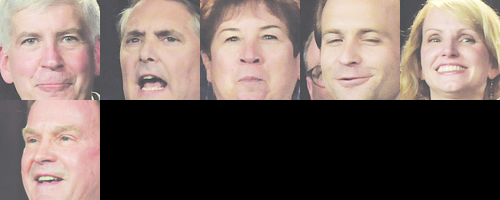

Results found in file a-3.png


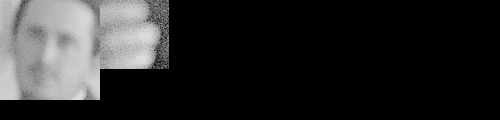

Results found in file a-0.png


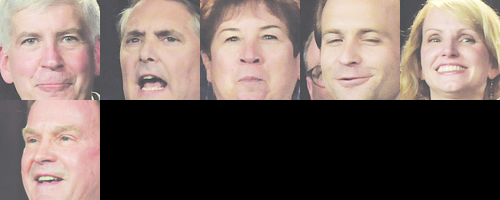

Results found in file a-1.png


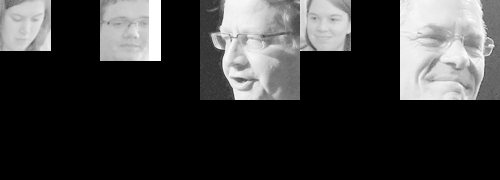

Results found in file a-10.png
But there were no faces in that file!
Results found in file a-13.png


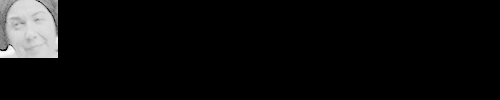

Results found in file a-2.png


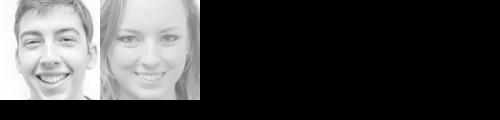

Results found in file a-3.png


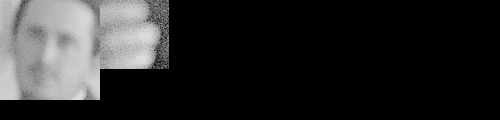

Results found in file a-8.png
But there were no faces in that file!


In [1]:
from zipfile import ZipFile 
from PIL import Image, ImageDraw
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe' #in windows: install and indicate path for tesseract.exe. Installer: https://github.com/UB-Mannheim/tesseract/wiki
import cv2 as cv
import numpy as np

### global variables ###
# loads the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')


### functions ###
# detects faces and returns a list of rectangles delimiting those faces from the image passed. threshold controls accuracy
def getBoundingBoxes(img, threshold, minNeighbors):
    #load color image and pass to grayscale
    cv_img = cv.imread(img)
    cv_image = cv.cvtColor(cv_img, cv.COLOR_BGR2GRAY)
    
    #binarize the image with the hope to get some improvement in the face detection
    #cv_image = cv.threshold(cv_image,170,255,cv.THRESH_BINARY)[1]
    
    #get the bounding boxes with an especified scale size
    face_bounding_boxes = face_cascade.detectMultiScale(cv_image,threshold,minNeighbors)
    return face_bounding_boxes

# detects and returns text from an image (preferably in grayscale)
def getText(img):
    image = Image.open(img)
    img_gray = image.convert('L')
    text = pytesseract.image_to_string(img_gray)
    return text

# passes the data of an image and returns an array of cropped faces in that image
def getFacesFromImage(image_data):
    face_images = []
    #we read our image and convert it to rgb (in case the image is a gif)
    img_color = image_data[0].convert("RGB")
    #we extract the bounding boxes, crop the image and store it in the array faces
    for x,y,w,h in image_data[1]:
        bounding_box = (x,y,x+w,y+h)
        face = img_color.crop(bounding_box)
        face_images.append(face)
    return face_images   

#opens a zip file with images and returns the images, bounding boxes and text in a dictionary
def extractData(zipfile):
    data = {}
    with ZipFile(zipfile, 'r') as myzip:
        info_lst = myzip.infolist()
        for elem in info_lst:
            try:
                with myzip.open(elem) as img:
                    pil_img = Image.open(img)
                    pil_img.save("img.png")

                data[elem.filename]=[pil_img]
                #print(elem.filename+': image loaded')
                data[elem.filename].append(getBoundingBoxes("img.png", 1.3, 5))
                #print(elem.filename+': bounding boxes loaded')
                data[elem.filename].append(getText("img.png"))
                #print(elem.filename+': text loaded')                
            except Exception as e:
                print(e)
    return data

# creates a contact sheet form an array of images and displays it
def displayContactSheet(images):
    first_image = images[0]
    contact_sheet=Image.new(first_image.mode, (500,100 + 100*(len(images)-1) // 5 ))
    x, y = (0,0)

    for img in images:
        # Lets paste the current image into the contact sheet
        img.thumbnail((100,100))
        contact_sheet.paste(img, (x,y))
        # Now we update our X position. If it is going to be the width of the image, then we set it to 0
        # and update Y as well to point to the next "line" of the contact sheet.
        if x+100 == contact_sheet.width:
            x=0
            y=y+100
        else:
            x=x+100

    #display the contact sheet
    display(contact_sheet)

#only shows images of the faces in an image if it contains the word passed 
def show_faces(data, word):
    for image_data in data:
        if word in data[image_data][2]:
            print('Results found in file '+ image_data)
            faces = getFacesFromImage(data[image_data])
            if len(faces) == 0:
                print('But there were no faces in that file!')
            else:
                displayContactSheet(faces)


### main ###
#stores each image,their bounding boxes and their text     
data = {} #data = {name:[PIL image, bounding boxes, text], name:[PIL image, bounding boxes, text], ...}

data = extractData('readonly/small_img.zip')
show_faces(data, "Christopher")
data = extractData('readonly/images.zip')
show_faces(data, "Mark")